In [1]:
!pip install -U sentence-transformers
!pip install umap-learn
!pip install scikit-learn-extra
!pip install coclust

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.0 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=cfc8e9c5be7f054c708aa4dc5b562c36473236ff9f2519a830987864a976973c
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.7 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=75223681714b6559cfa6dc478d12707784c7353963ca326b2b5d064760b95a32
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Succe

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
def load_data():
    ng20 = fetch_20newsgroups(subset='test')
    corpus = ng20.data[:2000]
    labels = ng20.target[:2000]
    df_labels = pd.DataFrame(labels)
    df_labels.rename(columns = {0:'label'}, inplace = True)
    df_corpus = pd.DataFrame(corpus)
    df_corpus.rename(columns = {0:'text'}, inplace = True)
    return df_corpus, df_labels

In [4]:
df_corpus, df_labels = load_data()

# Pré-traitement des données textuelles

On enchaîne dans la fonction data_preprocessing les méthodes de nettoyage classiques.
* Suppression des tag HTML
* Conservation des mots uniquement
* Passage en minuscule
* Suppression des mots vides
* Tokenization
* Lemmatisation
* Réassemblage des articles

In [5]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('english') # définir les stop_words
lemmatizer = WordNetLemmatizer()

def data_preprocessing(review):

  # nettoyage des données
  article = re.sub(re.compile('<.*?>'), '', review) #removing html tags
  article =  re.sub('[^A-Za-z0-9]+', ' ', review) #taking only words

  # miniscule
  article = article.lower()

  # tokenization
  tokens = nltk.word_tokenize(article) # converts articles to tokens

  # stop_words removal
  article = [word for word in tokens if word not in stop_words] #removing stop words

  # lemmatization
  article = [lemmatizer.lemmatize(word) for word in article]

  # join words in preprocessed review
  article = ' '.join(article)

  return article

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
# On applique le pré-traitement à nos données df_corpus
df_corpus['preprocessed_text'] = df_corpus['text'].apply(lambda article: data_preprocessing(article))
df_corpus

,text,preprocessed_text
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,v064mb9k ubvmsd cc buffalo edu neil b gandler ...
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,rick miller rick ee uwm edu subject x face org...
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,mathew mathew mantis co uk subject strong weak...
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,bakken c arizona edu dave bakken subject saudi...
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,livesey solntze wpd sgi com jon livesey subjec...
...,...,...
1995,Organization: Queen's University at Kingston\n...,organization queen university kingston leek qu...
1996,From: stevek@cellar.org (Steve Kraisler)\nSubj...,stevek cellar org steve kraisler subject atf b...
1997,From: pmetzger@snark.shearson.com (Perry E. Me...,pmetzger snark shearson com perry e metzger su...
1998,From: d89-mad@ludd.luth.se (Mattias ]slund)\nS...,d89 mad ludd luth se mattias slund subject rem...


In [7]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [8]:
embeddings = model.encode(df_corpus['preprocessed_text'])

In [10]:
embeddings.shape

(2000, 384)

In [11]:
import umap

# Define the number of components to keep

def UMAP_method(data, n_comp):

    # Initialize UMAP object
    umap_obj = umap.UMAP(n_components=n_comp)


    # Fit PCA on embeddings
    umap_obj.fit(data)

    # Apply dimensionality reduction
    df_umap = pd.DataFrame(umap_obj.transform(data))

    # Add label column to the new dataframe
    df_umap['label'] = df_labels

    # Rename columns
    df_umap.columns = ['UMAP'+str(i+1) for i in range(n_comp)] + ['label']

    return df_umap

In [12]:
df_umap = UMAP_method(embeddings, 20)
df_umap

,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAP10,...,UMAP12,UMAP13,UMAP14,UMAP15,UMAP16,UMAP17,UMAP18,UMAP19,UMAP20,label
0,8.019759,8.880139,6.221808,9.642448,7.105849,9.061367,8.439430,7.367001,5.327941,4.353552,...,2.869390,6.372728,8.324372,4.632182,5.918482,6.904509,5.087836,5.157550,6.708541,7
1,7.636112,9.706659,5.883526,10.164239,7.033180,8.904654,8.290729,7.464945,4.777112,3.880942,...,3.051707,6.556183,8.108972,4.611482,6.438631,6.677457,5.146540,4.808195,7.086389,5
2,4.891511,8.698023,5.874730,10.369375,7.505790,9.032292,8.720818,7.004446,3.967831,4.772208,...,3.287349,6.318378,8.642412,3.829433,7.605788,6.500151,5.597198,4.718615,7.206350,0
3,4.728251,8.432843,5.015924,10.752955,7.477342,8.865671,9.045288,7.488682,4.228253,4.663521,...,2.432578,6.154857,9.022309,3.552040,7.173289,6.774705,5.543282,4.809241,7.289450,17
4,4.955003,8.706964,5.726246,10.589607,7.303355,8.851772,8.919250,7.079741,3.997859,4.546508,...,3.151829,6.373473,8.611609,3.681095,7.369683,6.544002,5.617069,4.783420,7.327768,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7.363183,9.927231,5.766542,10.026882,6.958433,9.017131,8.464906,7.727479,5.276331,3.743180,...,2.708103,6.451794,8.273045,4.689724,6.098352,6.893953,4.797452,4.854872,6.843769,12
1996,6.257947,8.134919,4.658093,10.594688,7.153475,8.183984,9.223770,7.411833,4.713820,4.885508,...,2.360881,6.460798,8.525300,3.519400,6.848128,7.091978,5.713432,4.955732,6.975213,16
1997,7.384445,9.382206,5.484826,9.264436,6.764579,8.580517,8.335409,7.643196,4.978471,4.274936,...,2.440264,6.581674,8.074244,4.620129,6.522799,7.064305,5.136124,5.204661,6.714801,11
1998,7.409976,10.422900,5.833281,9.934738,7.070314,8.839949,8.373713,7.641255,4.797595,3.564292,...,3.257428,6.643125,7.960358,4.653595,6.303117,6.512459,4.951131,4.858377,7.325506,2


In [13]:
def plot_elbow(n_range, data):
    # Try different values of k
    k_values = range(1, n_range)
    inertia_values = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.plot(k_values, inertia_values, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

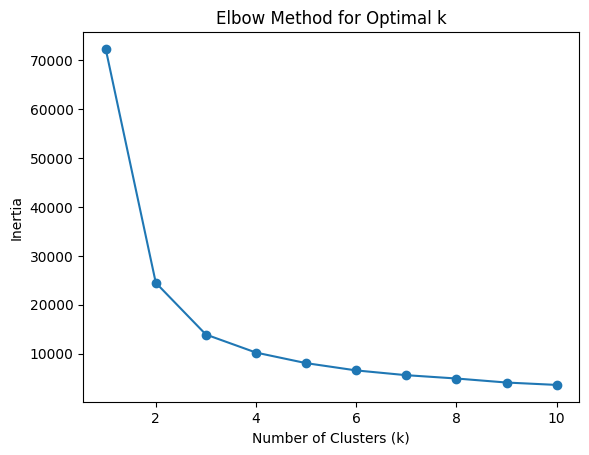

In [14]:
plot_elbow(11, df_umap.iloc[:-1])

In [15]:
def plot_clusters(num_clusters):
    # Créer l'objet KMeans avec l'initialisation K-means++
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # Initialize LabelEncoder object
    le = LabelEncoder()

    # Fit and transform the label column to numerical values
    df_umap['label'] = le.fit_transform(df_umap['label'])

    # Plot scatter plot
    plt.scatter(df_umap['UMAP1'], df_umap['UMAP2'], c=df_umap['label'], cmap='viridis')
    plt.colorbar()
    plt.show()

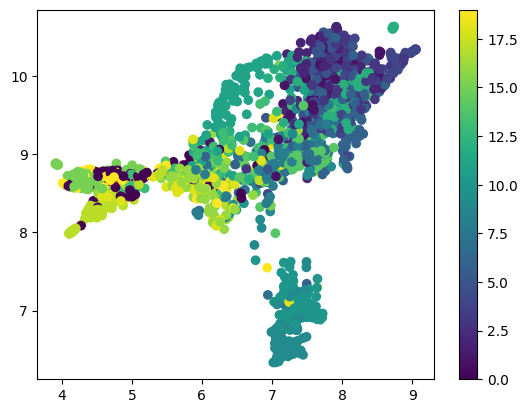

In [16]:
plot_clusters(3)

In [17]:
def kmeans_method(data, labels,  num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    kmeans.fit(data)
    kmeans_labels = kmeans.labels_
    nmi_kpp_umap = normalized_mutual_info_score(labels, kmeans_labels )
    ari_kpp_umap = adjusted_rand_score(labels, kmeans_labels)
    return nmi_kpp_umap, ari_kpp_umap

In [18]:
nmi_kpp_umap, ari_kpp_umap = kmeans_method(df_umap.iloc[:,:-1], df_labels['label'],  3)
print("NMI pour kmeans++ avec la PCA:", nmi_kpp_umap)
print("ARI pour kmeans++ avec la PCA :", ari_kpp_umap)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


NMI pour kmeans++ avec la PCA: 0.3538269161083965
ARI pour kmeans++ avec la PCA : 0.09921857618971688
